# Particle Flow Network to Handle Single Track Multiple Cluster Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
import scipy.constants as spc

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

## Declare GPUS - Import TensorFlow

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "5"

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']

# get_available_gpus()

# Import EnergyFlow 

In [3]:
import energyflow as ef
from energyflow.archs import PFN
print('Energy Flow Version: '+str(ef.__version__))

Energy Flow Version: 1.3.2


# Load Data
### Data Including Tracks
### X = [Energy, Eta, Phi, rPerp, Track Flag, Layer]
### Y = [truthPartE, truthTrackPt, cluster_ENG_CALIB_TOT]

In [4]:
t0 = t.time()
Xraw = np.load('/data/atlas/rbate/X_STMC_502_files.npy', mmap_mode='r')[:175000,:,:]
Yraw = np.load('/data/atlas/rbate/Y_STMC_502_files.npy', mmap_mode='r')[:175000,:]

X = np.lib.format.open_memmap('/data/atlas/rbate/X_STMC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 5))
np.copyto(dst=X, src=Xraw[:,:,:5], casting='same_kind', where=True)

Y = np.lib.format.open_memmap('/data/atlas/rbate/Y_STMC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0]))
np.copyto(dst=Y, src=Yraw[:,0], casting='same_kind', where=True)

t1 = t.time()
print('Time to load memory mapped data: {} (s)'.format(t1-t0))
print(Xraw.shape)
print(Yraw.shape)

Time to load memory mapped data: 42.323649644851685 (s)
(175000, 1086, 6)
(175000, 3)


# Particle Truth Energy Target

In [5]:
# the target energy values
target_zero_mask = Yraw[:,0] > .05
Y = np.log(Yraw[target_zero_mask,0])
print('Any targets below 50 GeV: '+str(np.count_nonzero(np.invert(target_zero_mask))))
print('Number of events: '+str(len(Y)))

Any targets below 50 GeV: 0
Number of events: 175000


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial


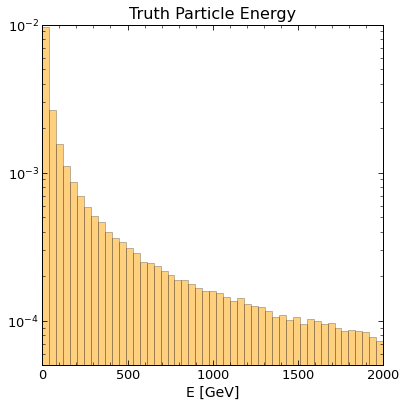

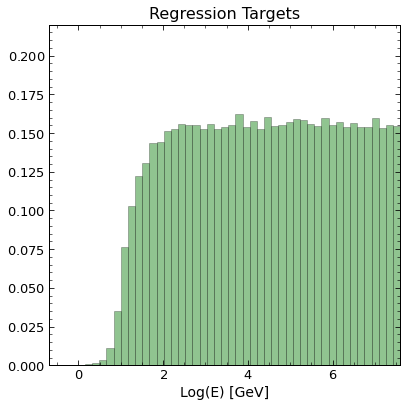

In [6]:
## RAW DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(0,2000,50,endpoint=True)
plt.hist(Yraw[:,0][target_zero_mask], color='orange', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='Particle Truth Energy')
plt.title('Truth Particle Energy', fontsize=16)
plt.xlabel('E [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.yscale('log')
plt.ylim(.00005,.01)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/EnergyTargets_STMC_raw_2021-07-26.png', format='png')
plt.show()

## NORMALIZED DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(np.log(.5), np.log(2000), 50, endpoint=True)
plt.hist(Y, color='forestgreen', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='log')
plt.title('Regression Targets', fontsize=16)
plt.xlabel('Log(E) [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.ylim(0,.22)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/EnergyTargets_STMC_log_2021-07-26.png', format='png')
plt.show()

## Deep Set Normalization

In [7]:
t0 = t.time()
## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

isnan = np.isnan(X[:,:,0])
anytruth = np.any(isnan)
print(anytruth)

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[:,:,2][phi_mask])
X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/cellPhi_std
t1 = t.time()
print('Time to Normalize: '+str(t1-t0)+' (s)')

False
Time to Normalize: 29.875126361846924 (s)


## Show Inputs

<Figure size 799.992x599.976 with 0 Axes>

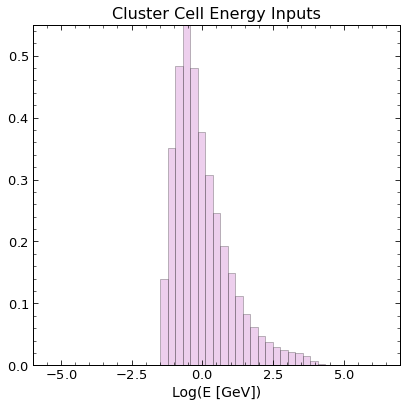

<Figure size 799.992x599.976 with 0 Axes>

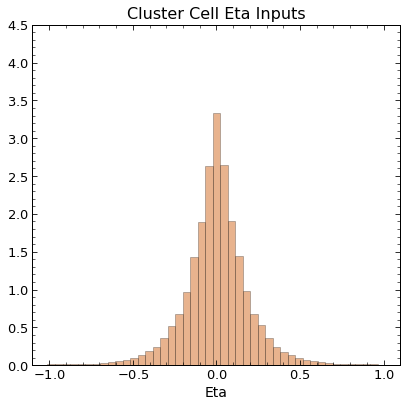

<Figure size 799.992x599.976 with 0 Axes>

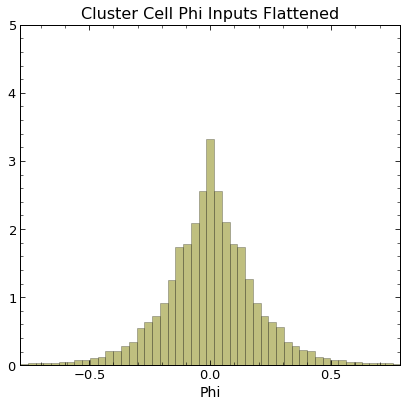

<Figure size 799.992x599.976 with 0 Axes>

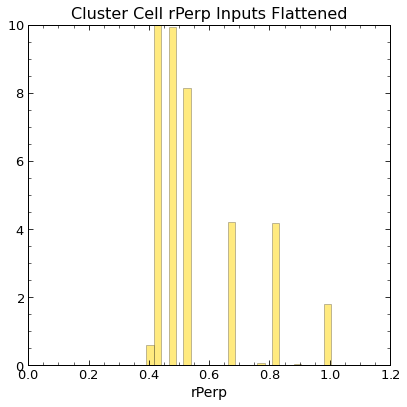

In [8]:
############
## ENERGY ##
############
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-6,7, 50, endpoint=True)
plt.hist(X[:,:,0][E_nonZeroMask], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Energy Inputs', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_E_2021-07-26.png', format='png')
plt.show()

#########
## ETA ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
etabins = np.linspace(-1.1,1.1,50, endpoint=True)
plt.hist(X[:,:,1][eta_mask], color='chocolate', bins=etabins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Eta Inputs', fontsize=16)
plt.xlabel('Eta', fontsize=14)
plt.xlim(np.min(etabins),np.max(etabins))
plt.ylim(0,4.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_Eta_2021-07-26.png', format='png')
plt.show()

#########
## PHI ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
phibins = np.linspace(-np.pi/4,np.pi/4,50, endpoint=True)
plt.hist(X[:,:,2][phi_mask], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
plt.xlabel('Phi', fontsize=14)
plt.xlim(np.min(phibins),np.max(phibins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_Phi_2021-07-26.png', format='png')
plt.show()

###########
## RPERP ##
###########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
Rbins = np.linspace(-0,1.2,50, endpoint=True)
plt.hist(X[:,:,3][rPerp_mask], color='gold', bins=Rbins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell rPerp Inputs Flattened', fontsize=16)
plt.xlabel('rPerp', fontsize=14)
plt.xlim(np.min(Rbins),np.max(Rbins))
plt.ylim(0,10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_rPerp_2021-07-26.png', format='png')
plt.show()

### Model Settings

In [9]:
# EFN regression example uses 75/10/15 split for 100,000 samples
train, val, test = dsu.tvt_num(X, tvt=(70, 15, 15))
print('train -- val -- test')
print(str(train)+' -- '+str(val)+' -- '+str(test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 100
batch_size = 3000

train -- val -- test
122500 -- 26250 -- 26250


#### Train/Val/Test Split

In [10]:
(x_train, x_val, x_test,
 y_train, y_val, y_test) = ef.utils.data_split(X, Y, val=val, test=test)

# Print out tensor shapes
print(np.shape(x_train))
print(np.shape(y_train))

(122500, 1086, 5)
(122500,)


### Build Particle Flow Network

In [11]:
netOpt = tf.keras.optimizers.Adam(
    learning_rate=.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

pfn = PFN(input_dim=5, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss,
          optimizer=netOpt, metrics=[])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

2022-02-08 19:29:26.197049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:89:00.0, compute capability: 7.5


### Train Model

In [12]:
t0 = t.time()
history = pfn.fit(x_train, y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=1)
t1 = t.time()

2022-02-08 19:29:47.162321: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2660700000 exceeds 10% of free system memory.
2022-02-08 19:29:50.379786: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2660700000 exceeds 10% of free system memory.
2022-02-08 19:29:53.263121: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
41/41 [==============================] - 19s 296ms/step - loss: 1188.9471 - val_loss: 11.8070
Epoch 2/100
41/41 [==============================] - 10s 238ms/step - loss: 7.6617 - val_loss: 5.4958
Epoch 3/100
41/41 [==============================] - 10s 248ms/step - loss: 4.1463 - val_loss: 3.0618
Epoch 4/100
41/41 [==============================] - 10s 238ms/step - loss: 2.1215 - val_loss: 1.5507
Epoch 5/100
41/41 [==============================] - 10s 242ms/step - loss: 1.3647 - val_loss: 1.2976
Epoch 6/100
41/41 [==============================] - 9s 212ms/step - loss: 1.0450 - val_loss: 1.0641
Epoch 7/100
41/41 [==============================] - 9s 231ms/step - loss: 0.9272 - val_loss: 1.0217
Epoch 8/100
41/41 [==============================] - 9s 225ms/step - loss: 0.8206 - val_loss: 1.1045
Epoch 9/100
41/41 [==============================] - 9s 217ms/step - loss: 0.7388 - val_loss: 0.7618
Epoch 10/100
41/41 [==============================] - 10s 242ms/step - loss: 0.600

2022-02-08 19:33:38.981730: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.55GiB (rounded to 1668096000)requested by op gradient_tape/model/sum/MatMul/MatMul_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-02-08 19:33:38.981817: I tensorflow/core/common_runtime/bfc_allocator.cc:1013] BFCAllocator dump for GPU_0_bfc
2022-02-08 19:33:38.981993: I tensorflow/core/common_runtime/bfc_allocator.cc:1020] Bin (256): 	Total Chunks: 39, Chunks in use: 39. 9.8KiB allocated for chunks. 9.8KiB in use in bin. 200B client-requested in use in bin.
2022-02-08 19:33:38.982046: I tensorflow/core/common_runtime/bfc_allocator.cc:1020] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 10.5KiB allocated for chunks. 10.5KiB in use in bin. 8.5KiB client-requested in use in bin.
202

ResourceExhaustedError:  OOM when allocating tensor with shape[3000,1086,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model/sum/MatMul/MatMul_1 (defined at usr/local/lib/python3.8/dist-packages/energyflow/archs/archbase.py:370) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1092]

Function call stack:
train_function


In [ ]:
print('Time to train: {} (s)'.format(t1-t0))
print('{} (min)'.format(((t1-t0)/60))
print('{} (hour)'.format((t1-t0)/3600))

### Loss Curves

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.plot(history.history['val_loss'], label="Validation")
plt.plot(history.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,1500)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(1000, 1.5, 'LR=1e-3', fontsize=13)
plt.text(1000, 1, 'Batch: 3000', fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/January/STMC_lossCurves_3000batch_LR1e-3_2021-07-26.png', format='png')
plt.show()

### Predictions

In [ ]:
preds = np.exp(pfn.predict(x_test, batch_size=3000).flatten())
print(preds.shape)

#### Histogram of Predictions

In [ ]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.exp(y_test), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E /[GeV])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('Regression_Plots/January/STMC_targetPreds_3000batch_LR1e-3_2021-07-26.png', format='png')
plt.show()

#### Analytics

#### Response Plot

In [ ]:
resplot = ru.responsePlot(x=np.exp(y_test), y=preds/np.exp(y_test),
                figfile='',
                statistic='median', xlabel='Particle Truth Energy', ylabel='Predicted Energy / Particle Truth Energy',
                atlas_x=.05, atlas_y=.96, simulation=True, cblabel='',
                textlist=[])
# Regression_Plots/July/STMC_responsePlot_3000batch_LR1e-3_2021-07-26.png

#### Resolution Plot

In [ ]:
resp_plot = ru.resolutionPlot(x=np.exp(y_test), y=preds/np.exp(y_test),
                    figfile='',
                    statistic='iqrOverMean', xlabel='Particle Truth Energy', ylabel='Energy IQR over Median',
                    atlas_x=.05, atlas_y=.96, simulation=True,
                    textlist=[])
# Regression_Plots/July/STMC_resolutionPlot_3000batch_LR1e-3_2021-07-26.png

### Save Model and History

In [ ]:
pfn.save('Models/pfn_base_trained_STMC_122500_2022-01-26')

In [ ]:
import pickle

with open('Models/pfn_base_trained_STMC_122500_history_2022-01-26.pickle', "wb") as hist_file:
    pickle.dump(history, hist_file)

# Train Custom Models
Notebook can be run separately from here

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
import scipy.constants as spc

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "5"
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from tensorflow.python.client import device_lib

## Define 'By Hand' Models

#### Particle Flow Base

In [3]:
def point_mask_fn(X, mask_val=0.):
    return K.cast(K.any(K.not_equal(X, mask_val), axis=-1), K.dtype(X))

def ParticleFlow_base(num_points, num_features, name="Russell Flow Network"):
    
    inputs = keras.Input(shape=(num_points, num_features), name='input')

    #============== Phi Layers ===============================================#
    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    #=========================================================================#
    
    #============== Aggregation Function (Sum) ===============================#
    lambda_layer = layers.Lambda(point_mask_fn,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')(
        [lambda_layer, activation_2])
    #=========================================================================#
    
    #============== F Layers =================================================#
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(1, name='output')(activation_5)
    activation_6 = layers.Activation('linear', name="activation_6")(dense_6)
    #=========================================================================#
    
    return keras.Model(inputs=inputs, outputs=activation_6, name=name)

#### Particle Flow With Dropout

In [4]:
def PFN_wDropout(num_points, num_features, name="PFN_w_dropout"):
    
    inputs = keras.Input(shape=(num_points, num_features), name='input')

    #============== Phi Layers With Dropout ==================================#
    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    dropout_0 = layers.Dropout(rate=.15, name='dropout_0')(activation_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(dropout_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    dropout_1 = layers.Dropout(rate=.15, name='dropout_1')(activation_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(dropout_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    dropout_2 = layers.Dropout(rate=.15, name='dropout_2')(activation_2)
    #=========================================================================#
    
    #============== Aggregration Function (Sum) ==============================#
    lambda_layer = layers.Lambda(point_mask_fn,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, activation_2])
    #=========================================================================#
    
    #============== F Layers With Dropout ====================================#
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    dropout_3 = layers.Dropout(rate=.15, name='dropout_3')(activation_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(dropout_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    dropout_4 = layers.Dropout(rate=.15, name='dropout_4')(activation_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(dropout_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    dropout_5 = layers.Dropout(rate=.15, name='dropout_5')(activation_5)
    
    dense_6 = layers.Dense(1, name='output')(activation_5)
    activation_6 = layers.Activation('linear', name="activation_6")(dense_6)
    #=========================================================================#
    
    return keras.Model(inputs=inputs, outputs=activation_6, name=name)

#### TNet and TDist Block

In [5]:
A = np.random.randint(low=0, high=10, size=(4,3))
B = np.random.randint(low=0, high=10, size=(3,3))
print(A)
print(B)

x = K.variable(value=A)
y = K.variable(value=B)

C = K.eval(K.dot(x,y))
print(C)

# D = K.eval(K.batch_dot(x,y))
# print(D)

E = tf.linalg.matmul(A,B)
print(E)

w = A.reshape((1,A.shape[0],A.shape[1]))
q = B.reshape((1,B.shape[0],B.shape[1]))
print(w.shape)
print(q.shape)
# w = K.variable(value=w)
# q = K.variable(value=q)
F = layers.Dot(axes=(2,1))([w,q])
print(F)

[[5 6 1]
 [2 5 9]
 [6 9 5]
 [8 4 4]]
[[7 5 3]
 [4 2 0]
 [9 6 0]]


2022-02-10 18:22:21.920523: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:214] Using CUDA malloc Async allocator for GPU: 0
2022-02-10 18:22:21.921026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:89:00.0, compute capability: 7.5


[[ 68.  43.  15.]
 [115.  74.   6.]
 [123.  78.  18.]
 [108.  72.  24.]]
tf.Tensor(
[[ 68  43  15]
 [115  74   6]
 [123  78  18]
 [108  72  24]], shape=(4, 3), dtype=int64)
(1, 4, 3)
(1, 3, 3)
tf.Tensor(
[[[ 68  43  15]
  [115  74   6]
  [123  78  18]
  [108  72  24]]], shape=(1, 4, 3), dtype=int64)


In [6]:
def tdist_block(x, mask, size: int, number: str):
    dense = layers.Dense(size)
    x = layers.TimeDistributed(dense, name='t_dist_'+number)(x, mask=mask)
    x = layers.Activation('relu', name='activation_'+number)(x)
    return x

def multiply(tensor1, tensor2):
    return K.dot(tensor1,tensor2)

In [7]:
def PFN_wTNet(num_points, num_features, name="Russell Flow Network"):
    
    inputs = keras.Input(shape=(num_points, num_features), name='input')

    #============== Masking for TNet =========================================#
    mask_tens = layers.Masking(mask_value=0.0, input_shape=shape)(inputs)
    keras_mask = mask_tens._keras_mask
    #=========================================================================#

    #============== TNet =====================================================#
    block_0 = tdist_block(inputs, mask=keras_mask, size=50, number='0')
    block_0 = tdist_block(inputs, mask=keras_mask, size=100, number='1')
    block_0 = tdist_block(inputs, mask=keras_mask, size=100, number='2')
    
    max_pool = layers.MaxPool1d(pool_size=num_points, name='tnet_0_MaxPool')(
        [block_2])
    
    tnet_0_block_0 = layers.Dense(100, activation='relu',
                                  name='tnet_0_dense_0')(max_pool) 
    tnet_0_block_1 = layers.Dense(50, activation='relu',
                                  name='tnet_0_dense_1')(tnet_0_block_0)
    
    vector_dense = layers.Dense(
        num_features**2,
        kernel_initializer='zeros',
        bias_initializer=keras.initializers.Constant(
            np.eye(num_points).flatten()),
        name='pre_matrix_0'
    )(mlp_tnet_1)
    
    mat_layer = layers.Reshape((num_points, num_points),
                               name='matrix_0')(vector_dense)
    
    mat_mul_layer = layers.Dot(axes=(-1,-2), name='matrix_multiply_0')
    mod_inputs = layers.TimeDistributed(mat_mul_layer, name='tdist_multiply')(
        [inputs, mat_layer])
    #=========================================================================#
    
    #============== T_Dist Phi Block =========================================#
    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(mod_inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    #=========================================================================#
    
    #============== Aggregation Function (Summation) =========================#
    
    # This is important as it produces a layer tensor of 1s and 0s
    # to be dotted with the output of the activation
    lambda_layer = layers.Lambda(point_mask_fn,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(-1,-1), name='sum')(
        [lambda_layer, activation_2])
    #=========================================================================#
    
    #============== F Block ==================================================#
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(1, name='output')(activation_5)
    activation_6 = layers.Activation('linear', name="activation_6")(dense_6)
    #=========================================================================#
    
    return keras.Model(inputs=inputs, outputs=activation_6, name=name)

## Load Data Files

In [8]:
t0 = t.time()
Xraw = np.load('/data/atlas/rbate/X_STMC_502_files.npy', mmap_mode='r')[:50000,:,:]
Yraw = np.load('/data/atlas/rbate/Y_STMC_502_files.npy', mmap_mode='r')[:50000,:]

X = np.lib.format.open_memmap('/data/atlas/rbate/X_STMC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 5))
np.copyto(dst=X, src=Xraw[:,:,:5], casting='same_kind', where=True)

Y = np.lib.format.open_memmap('/data/atlas/rbate/Y_STMC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0]))
np.copyto(dst=Y, src=Yraw[:,0], casting='same_kind', where=True)

t1 = t.time()
print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

Time to load memory mapped data: 4.2631614208221436 (s)


In [9]:
t0 = t.time()
## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[:,:,2][phi_mask])
X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/cellPhi_std
t1 = t.time()
print('Time to Normalize: '+str(t1-t0)+' (s)')

Time to Normalize: 2.2668747901916504 (s)


In [10]:
# the target energy values
target_zero_mask = Yraw[:,0] > .05
Y = np.log(Yraw[target_zero_mask,0])
print('Any targets below 50 GeV: '+str(np.count_nonzero(np.invert(target_zero_mask))))
print('Number of events: '+str(len(Y)))

Any targets below 50 GeV: 0
Number of events: 50000


### Shuffle Split

In [11]:
train_num, val_num, test_num = dsu.tvt_num(X, tvt=(70,15,15))
print(train_num, val_num, test_num)

35000 7500 7500


In [12]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices,:,:]
Y = Y[indices]

In [13]:
X_train = X[:train_num,:,:]
Y_train = Y[:train_num].reshape((train_num,1))

X_val = X[train_num:train_num+val_num,:,:]
Y_val = Y[train_num:train_num+val_num].reshape((val_num,1))

X_test = X[train_num+val_num:,:,:]
Y_test = Y[train_num+val_num:]

In [14]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(35000, 1086, 5)
(7500, 1086, 5)
(35000, 1)
(7500, 1)


In [15]:
import matplotlib.pyplot as plt

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial


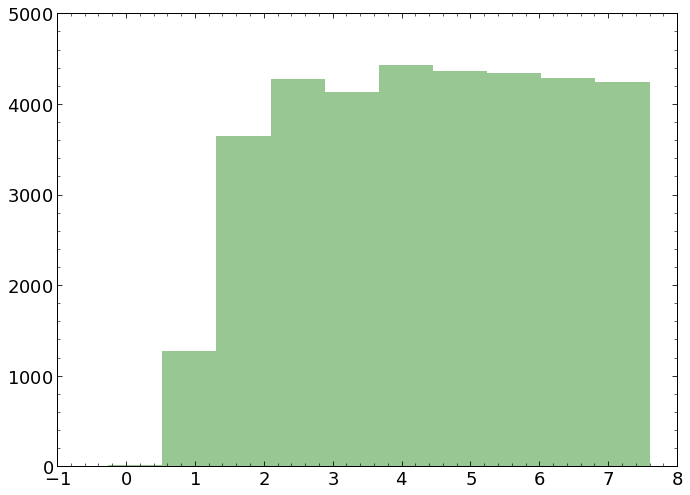

In [16]:
plt.hist(Y_train)
plt.show()


## Compile Model

In [17]:
pfn_dropout = PFN_wDropout(num_points = X.shape[1], num_features = X.shape[2],
                             name="pfn_dropout")
pfn_dropout.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-3))
pfn_dropout.summary()

Model: "pfn_dropout"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1086, 5)]    0                                            
__________________________________________________________________________________________________
t_dist_0 (TimeDistributed)      (None, 1086, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 1086, 100)    0           t_dist_0[0][0]                   
__________________________________________________________________________________________________
dropout_0 (Dropout)             (None, 1086, 100)    0           activation_0[0][0]               
________________________________________________________________________________________

## Train Model

In [18]:
history_dropout = pfn_dropout.fit(X_train,
                       Y_train,
                       batch_size=2000,
                       validation_data=(X_val, Y_val),
                       epochs=10,
                       verbose=1)

2022-02-10 18:23:35.444309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
18/18 [==============================] - 6s 233ms/step - loss: 16.8678 - val_loss: 6.0130
Epoch 2/10
18/18 [==============================] - 3s 187ms/step - loss: 5.2161 - val_loss: 4.7759
Epoch 3/10
18/18 [==============================] - 3s 188ms/step - loss: 4.1561 - val_loss: 3.6396
Epoch 4/10
18/18 [==============================] - 3s 190ms/step - loss: 3.2972 - val_loss: 2.3922
Epoch 5/10
18/18 [==============================] - 3s 184ms/step - loss: 1.9572 - val_loss: 1.0329
Epoch 6/10
18/18 [==============================] - 4s 199ms/step - loss: 1.1226 - val_loss: 0.9382
Epoch 7/10
18/18 [==============================] - 4s 202ms/step - loss: 0.8684 - val_loss: 0.6671
Epoch 8/10
18/18 [==============================] - 4s 202ms/step - loss: 0.7289 - val_loss: 0.7172
Epoch 9/10
18/18 [==============================] - 4s 201ms/step - loss: 0.6578 - val_loss: 0.8088
Epoch 10/10
18/18 [==============================] - 4s 209ms/step - loss: 0.5830 - val_loss: 1.108

## Data Pipeline With tf Dataset

In [26]:
tot_evt = X.shape[0]
BATCH_SIZE = 1000
Nbatch = np.floor(tot_evt/BATCH_SIZE).astype(int)
print(Nbatch)

train_num, val_num, test_num = dsu.tvt_num(X, tvt=(10,15,15))
print(train_num, val_num, test_num)

50
12500 18750 18750


In [27]:
data = tf.data.Dataset.from_tensor_slices((X, Y))
data.shuffle(buffer_size = 10000)

data_train = data.skip(val_num+test_num)
data_test = data.take(val_num+test_num)
data_val = data_test.skip(test_num)
data_test = data_test.take(test_num)

print(data_train.cardinality().numpy())
print(data_val.cardinality().numpy())
print(data_test.cardinality().numpy())

12500
18750
18750


### Batch Data

In [19]:
data_train.batch(batch_size=BATCH_SIZE, drop_remainder=False)
data_val.batch(batch_size=BATCH_SIZE, drop_remainder=False)
data_test.batch(batch_size=BATCH_SIZE, drop_remainder=False)

<BatchDataset shapes: ((None, 1086, 5), (None,)), types: (tf.float64, tf.float64)>

In [28]:
data_train.cardinality().numpy()

12500